<a href="https://colab.research.google.com/github/gpasxos/large-scale-optimization/blob/main/CVX_NN_training.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# Training Neural Networks

This notebook is a companion for learning the back-propagation method and other first-order methods for training neural networks.

## MNIST Classification

This is a classification problem where we are given a list of 784-bit pictures representing scanned hand-written digits, and the task is to determine for each picture which of the ten digits it represents. First, let us pull the data from torchvision and inspect the training and test samples.

In [ ]:
import torch
from torchvision import datasets, transforms
import numpy as np
import matplotlib.pyplot as plt

# Download and load MNIST
transform = transforms.ToTensor()

train_dataset = datasets.MNIST(
    root="./data",
    train=True,
    download=True,
    transform=transform
)

test_dataset = datasets.MNIST(
    root="./data",
    train=False,
    download=True,
    transform=transform
)

print(f"Training samples: {len(train_dataset)}")
print(f"Test samples: {len(test_dataset)}")

Training samples: 60000
Test samples: 10000


Lets look at the details of this problem


Single example:
 Image shape: torch.Size([1, 28, 28])
 Label: 5
 Pixel range: 0.0 to 1.0


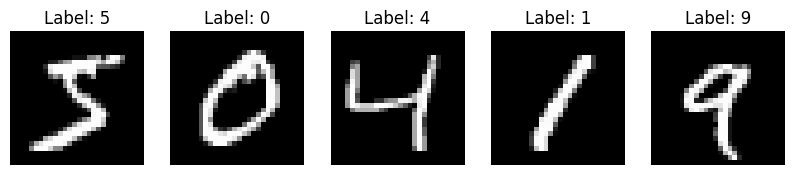


Class distribution:
 Digit 0: 5923
 Digit 1: 6742
 Digit 2: 5958
 Digit 3: 6131
 Digit 4: 5842
 Digit 5: 5421
 Digit 6: 5918
 Digit 7: 6265
 Digit 8: 5851
 Digit 9: 5949


In [ ]:
# Inspect a single example
x, y = train_dataset[0]
print("\nSingle example:")
print(" Image shape:", x.shape)
print(" Label:", y)
print(" Pixel range:", x.min().item(), "to", x.max().item())

# Visualize a few digits
fig, axes = plt.subplots(1, 5, figsize=(10, 3))
for i in range(5):
    img, label = train_dataset[i]
    axes[i].imshow(img.squeeze(), cmap="gray")
    axes[i].set_title(f"Label: {label}")
    axes[i].axis("off")
plt.show()

# Class distribution
labels = np.array([train_dataset[i][1] for i in range(len(train_dataset))])
unique, counts = np.unique(labels, return_counts=True)

print("\nClass distribution:")
for u, c in zip(unique, counts):
    print(f" Digit {u}: {c}")

## Perceptron on MNIST (linear classifier, non-linear problem)

First, for simplicity of exposition, we will restrict our MNIST to a binary classification problem, restricting to a capability to recognize only digits $\{0,1\}$, and using labels $\{-1,1\}$ respectively.

In [ ]:

X_list = []
y_list = []

for img, label in train_dataset:
    if label == 0:
        X_list.append(img.view(-1))
        y_list.append(-1)   # class -1
    elif label == 1:
        X_list.append(img.view(-1))
        y_list.append(1)    # class +1

X_perceptron = torch.stack(X_list).numpy()
y_perceptron = np.array(y_list)

print("Number of samples:", X_perceptron.shape[0])
print("Dimension of each input:", X_perceptron.shape[1])

Number of samples: 12665
Dimension of each input: 784


Add bias term by augmenting the data

In [ ]:
X_perceptron = np.hstack([X_perceptron, np.ones((X_perceptron.shape[0], 1))])

Let's visualize a few examples to show the problem

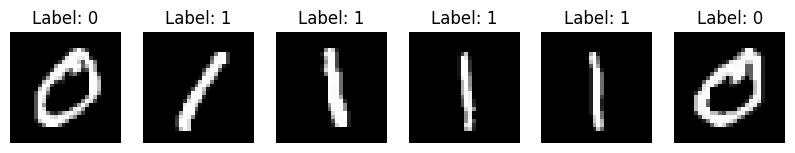

In [ ]:
fig, axes = plt.subplots(1, 6, figsize=(10, 2))

idx = 0
for i in range(len(train_dataset)):
    img, label = train_dataset[i]
    if label in [0, 1]:
        axes[idx].imshow(img.squeeze(), cmap="gray")
        axes[idx].set_title(f"Label: {label}")
        axes[idx].axis("off")
        idx += 1
    if idx == 6:
        break

plt.show()

Next, we introduce the perceptron prediction model, which is a single layer of neurons with non-smooth activation function (sign): $f(x) = sign(w^T x)$.

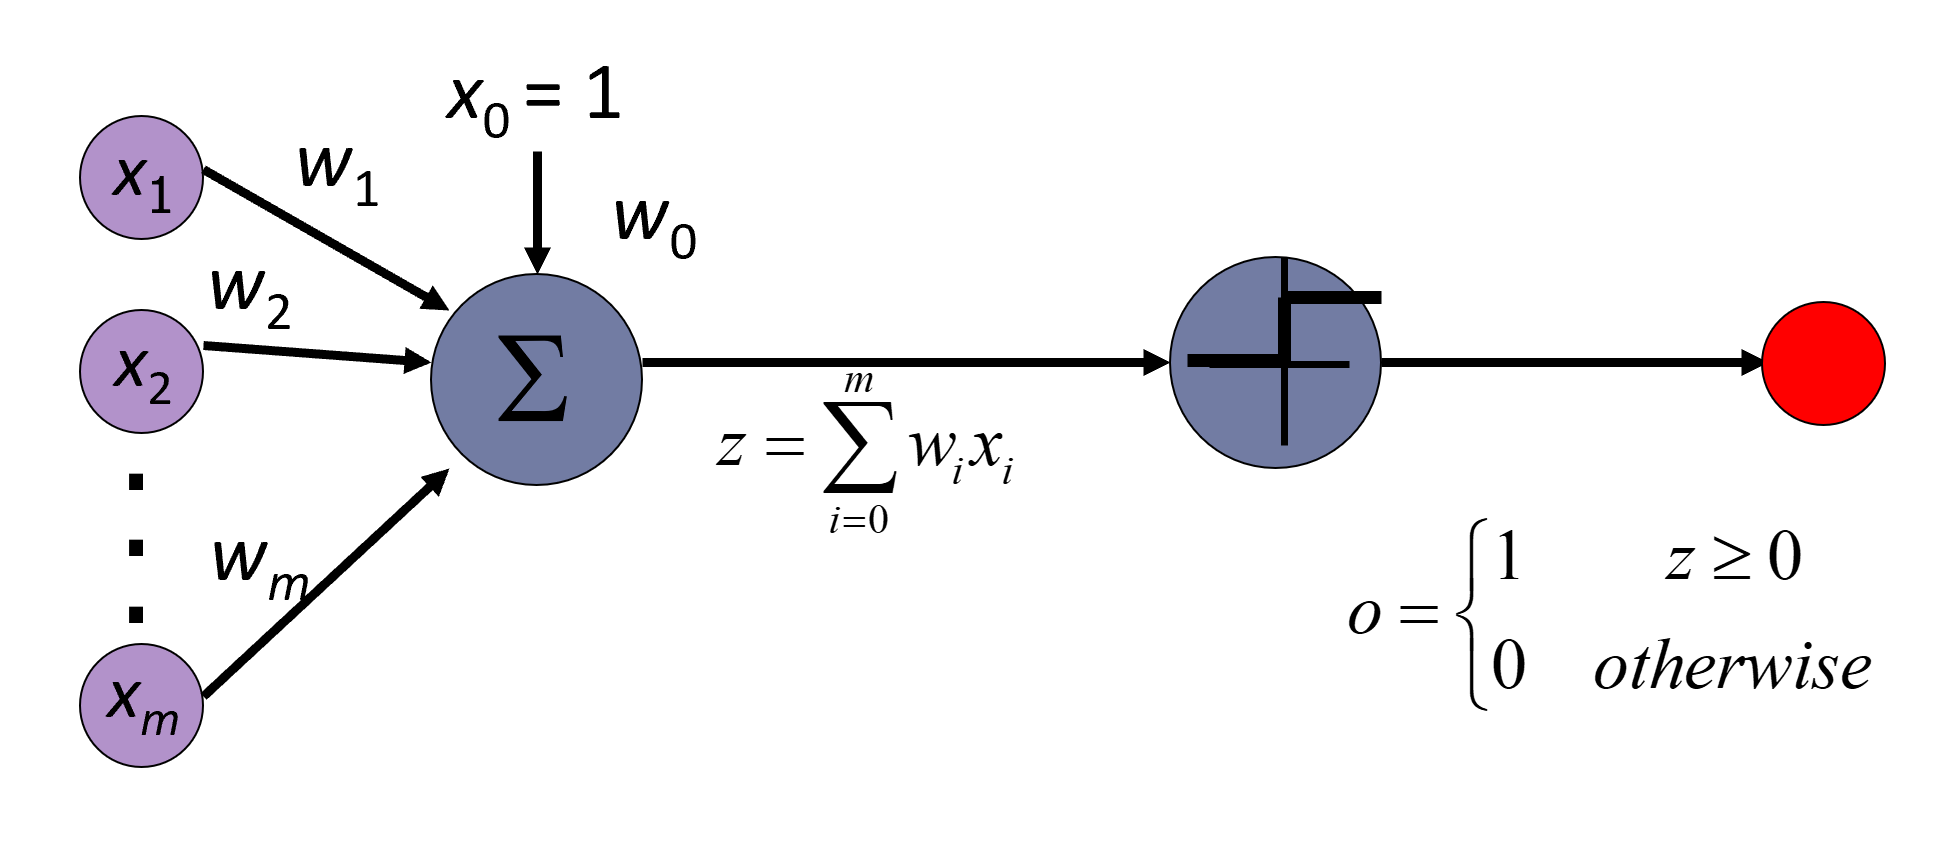

In [ ]:
# yields 1 if w^Tx is positive and -1 if it is negative
def perceptron_predict(w, X):
    return np.sign(X @ w)

To train the perceptron, we would like to use a loss function that measures the difference between $y_i$ and $sign(w^Tx_i)$, but we can not directly use the sign function, since its gradient is zero almost everywhere and therefore does not provide information for improvement. Instead, we introduce a surrogate convex loss function defined on the weights.

Let $x_i\in [0,1]^{784}$ be the vector input for datum $i$, and $y_i\in \{-1,+1\}$ be the label of the datum $i=1,\dots, N$, where $N$ is the size of the training set.

Our empirical risk minimization will have the form:
$$f(w) = \frac{1}N\sum_{i=1}^N \ell (-y_iw^Tx_i)$$ with a smooth surrogate of the 0-1 loss:
$$\ell(u) = \log(1+e^u)$$

<details>
In vector form this can be written as:
$$f(w) = L(-diag(y)Xw)$$
where
$$L(z) = \frac{1}N\sum_{i=1}^N\ell(z_i)$$
<details>

Why this works? Notice, that for correct perceptron prediction we require $w^Tx_i$ to be negative when  $y_i=-1$ and positive when $y_i=1$, and we can write both conditions compactly as $y_i w^T x_i>0$. Then, we see that $\ell$ has a signmoid form that yields almost zero when $y_i w^T x_i>0$ and has a steeply increasing loss that is a function of $-y_i w^T x_i$. $L$ is also convex and smooth, which allows us to apply our gradient techniques.

In [ ]:
def logistic_loss(w, X, y):
    """
    f(w) = (1/N) sum_i log(1 + exp(-y_i <x_i, w>))
    """
    margins = -y * (X @ w)
    return np.mean(np.log(1 + np.exp(margins)))

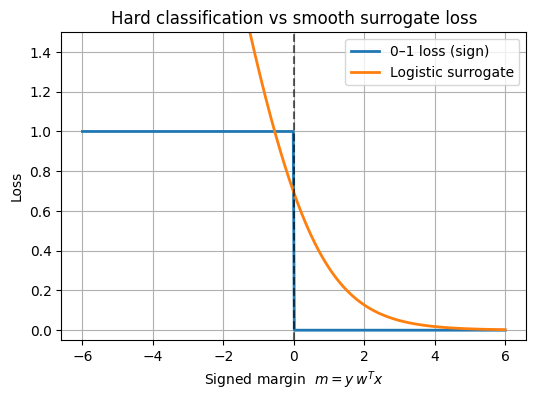

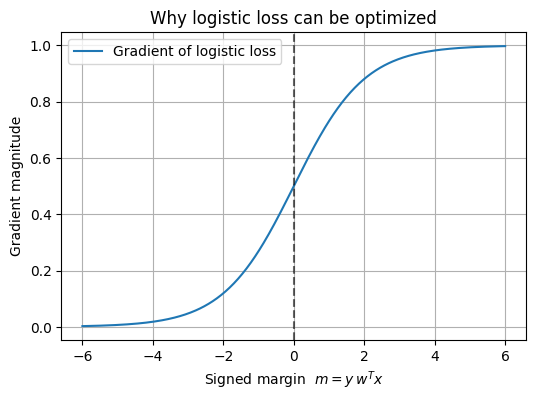

In [ ]:
# Signed margin values
m = np.linspace(-6, 6, 400)

# Hard 0-1 loss (via sign)
zo_loss_f = (m <= 0).astype(float)

# Logistic surrogate loss ℓ(-m) = log(1 + exp(-m))
lo_loss_f = np.log(1 + np.exp(-m))

plt.figure(figsize=(6,4))
plt.plot(m, zo_loss_f, label="0–1 loss (sign)", linewidth=2)
plt.plot(m, lo_loss_f, label="Logistic surrogate", linewidth=2)

plt.axvline(0, color="k", linestyle="--", alpha=0.6)
plt.xlabel(r"Signed margin  $m = y\,w^T x$")
plt.ylabel("Loss")
plt.title("Hard classification vs smooth surrogate loss")
plt.ylim(-0.05, 1.5)
plt.grid(True)
plt.legend()
plt.show()

sigmoid_f = 1 / (1 + np.exp(-m))

plt.figure(figsize=(6,4))
plt.plot(m, sigmoid_f, label="Gradient of logistic loss")
plt.axvline(0, color="k", linestyle="--", alpha=0.6)
plt.xlabel(r"Signed margin  $m = y\,w^T x$")
plt.ylabel("Gradient magnitude")
plt.title("Why logistic loss can be optimized")
plt.grid(True)
plt.legend()
plt.show()

We can start training the perceptron using our restricted MNIST data, to find the best possible weights $w^*$ that solve the empirical loss minimization problem:

$$
minimize_w f(w)
$$

To find the gradient $\nabla_w f(w)$, we start with the loss for a single datum
$$\ell'(u)= \sigma(u)=\frac{1}{1+e^{-u}}$$
By the chain rule:
$$\nabla_w\ell(-y_iw^Tx_i)=-y_ix_i\sigma(-y_iw^Tx_i)$$
Hence
$$\nabla_w f(w)=-\frac{1}N\sum_{i=1}^Ny_ix_i\sigma(-y_iw^Tx_i)$$

In [ ]:
def logistic_gradient(w, X, y):
    """
    Gradient of the logistic loss
    """
    margins = -y * (X @ w)
    sigma = 1 / (1 + np.exp(-margins))   # sigmoid
    grad = (-y[:, None] * X) * sigma[:, None]
    return np.mean(grad, axis=0)


Then, let us introduce three algorithms, the standard Gradient Descent, where we compute the full gradient (on the entire dataset) the  Stochastic Gradient Descent where we comptue a random direction at each iteration, and a mini-batch version of it, where we compute few direction of the subgradient at each iteration.

In [ ]:
# Gradient descent
def gradient_descent(X, y, lr=0.1, n_iters=50):
    w = np.zeros(X.shape[1])
    losses = []

    for _ in range(n_iters):
        grad = logistic_gradient(w, X, y)
        w -= lr * grad
        losses.append(logistic_loss(w, X, y))

    return w, losses

# Stochastic gradient descent
def stochastic_gradient_descent(X, y, lr=0.1, n_iters=200):
    w = np.zeros(X.shape[1])
    losses = []
    N = X.shape[0]

    for _ in range(n_iters):
        i = np.random.randint(N)
        margin = -y[i] * (X[i] @ w)
        sigma = 1 / (1 + np.exp(-margin))
        grad = -y[i] * X[i] * sigma

        w -= lr * grad
        losses.append(logistic_loss(w, X, y))

    return w, losses

# Mini-batch gradient descent
def minibatch_gradient_descent(X, y, lr=0.1, n_iters=100, batch_size=32):
    w = np.zeros(X.shape[1])
    losses = []
    N = X.shape[0]

    for _ in range(n_iters):
        idx = np.random.choice(N, batch_size, replace=False)
        grad = logistic_gradient(w, X[idx], y[idx])
        w -= lr * grad
        losses.append(logistic_loss(w, X, y))

    return w, losses

Lets train the perceptron using all three algorithms.

In [ ]:
w_gd, losses_gd = gradient_descent(X_perceptron, y_perceptron, lr=0.5, n_iters=30)
w_sgd, losses_sgd = stochastic_gradient_descent(X_perceptron, y_perceptron, lr=0.5, n_iters=2000)
w_mgd, losses_mgd = minibatch_gradient_descent(X_perceptron, y_perceptron, lr=0.5, n_iters=300, batch_size=64)

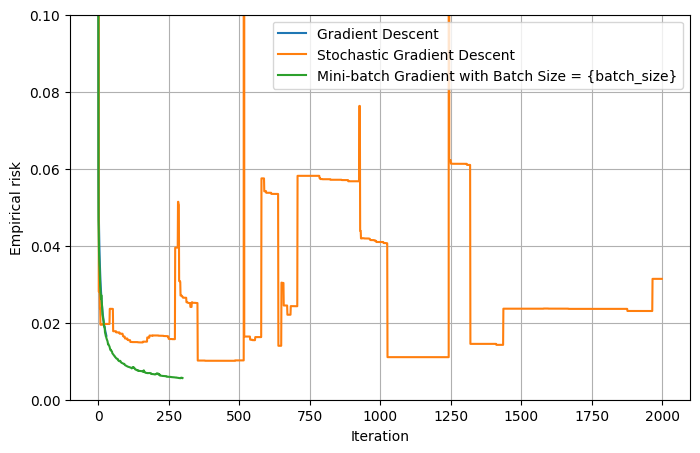

Training accuracy (GD):  0.9974733517568101
Training accuracy (SGD): 0.9969206474536123
Training accuracy (MGD): 0.9985787603632057


In [ ]:
# ------------------------------------------------------------
# Compare convergence behavior
# ------------------------------------------------------------

plt.figure(figsize=(8,5))
plt.plot(losses_gd, label="Gradient Descent")
plt.plot(losses_sgd, label="Stochastic Gradient Descent")
plt.plot(losses_mgd, label="Mini-batch Gradient with Batch Size = {batch_size}")
plt.xlabel("Iteration")
plt.ylabel("Empirical risk")
plt.ylim(0, 0.1)
plt.legend()
plt.grid(True)
plt.show()

# ------------------------------------------------------------
# Compare classification accuracy
# ------------------------------------------------------------

pred_gd = perceptron_predict(w_gd, X_perceptron)
pred_sgd = perceptron_predict(w_sgd, X_perceptron)
pred_mgd = perceptron_predict(w_mgd, X_perceptron)

acc_gd = np.mean(pred_gd == y_perceptron)
acc_sgd = np.mean(pred_sgd == y_perceptron)
acc_mgd = np.mean(pred_mgd == y_perceptron)

print("Training accuracy (GD): ", acc_gd)
print("Training accuracy (SGD):", acc_sgd)
print("Training accuracy (MGD):", acc_mgd)


## Back propagation for feed-forward Neural Network

Next, we will generalize the perceptron by introducing a simple multi-layer feed-forward neural network with $L$ layers. Our network has the following form:

$x\to z^1 = W^1 x + b^1 \to \sigma(z^1) \to z^2 = W^2 \sigma(z^1)+ b^2\to \sigma(z^2) \to \dots \to z^L = W^L \sigma(z^{L-1}) + b^L→ \hat y$

where $\sigma$ is the activation function.

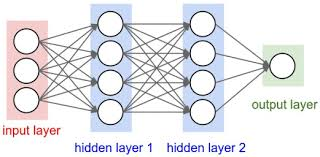

### One-hidden-layer neural network (quadratic loss)

We consider a feed-forward neural network with one hidden layer. Note: In this toy example, we use ReLU in the hidden layer and a linear output with squared error. Later, when we switch to multi-class classification (MNIST), the output layer will use softmax and the loss will be cross-entropy. The backpropagation principle remains exactly the same; only the computation of the gradient of the last layer changes.

Given an input vector $x \in \mathbb{R}^d$, the forward pass is

$$
z^1 = W^1 x + b^1 \in \mathbb{R}^m
$$

$$
h = \sigma(z^1)
$$

$$
z^2 = W^2 h + b^2 \in \mathbb{R}
$$

$$
\hat y = z^2
$$

We use the squared loss for a single training example $(x,y)$:

$$
\ell(\hat y, y) = \frac{1}{2}(\hat y - y)^2.
$$

Define the output error

$$
\delta^2 = \frac{\partial \ell}{\partial z^2} = \hat y - y.
$$

The gradients of the second-layer parameters are

$$
\frac{\partial \ell}{\partial W^2} = \delta^2 h^\top,
\qquad
\frac{\partial \ell}{\partial b^2} = \delta^2.
$$

The gradient with respect to the hidden activations is

$$
\delta h = (W^2)^\top \delta^2.
$$

Applying the chain rule through the nonlinearity,

$$
\delta^1 = \delta h \odot \sigma'(z^1).
$$

The gradients of the first-layer parameters are

$$
\frac{\partial \ell}{\partial W^1} = \delta^1 x^\top,
\qquad
\frac{\partial \ell}{\partial b^1} = \delta^1.
$$

This completes the backpropagation computation for one training example.

In [ ]:
rng = np.random.default_rng(0)

# dimensions
d = 4   # input dimension
m = 3   # hidden layer size

# parameters
W1 = rng.standard_normal((m, d))
b1 = np.zeros(m)

W2 = rng.standard_normal((1, m))
b2 = np.zeros(1)

# activation is $\sigma(z^1) = \text{ReLU}(z^1)$ here

def relu(z):
    return np.maximum(0.0, z)

def relu_grad(z):
    return (z > 0).astype(float)

# squared loss
def squared_loss(y_hat, y):
    return 0.5 * (y_hat - y)**2

# single data point
x = rng.standard_normal(d)
y = np.array([1.0])

# forward pass
z1 = W1 @ x + b1
h = relu(z1)
z2 = W2 @ h + b2
y_hat = z2

loss = squared_loss(y_hat, y)

print("Prediction:", y_hat.item())
print("Loss:", loss.item())


Prediction: -1.804757968185148
Loss: 3.93333363004904


In [ ]:
# backward pass (closed-form)

# output layer
delta2 = y_hat - y                      # scalar
dW2 = delta2 * h                        # (1, m)
db2 = delta2                            # (1,)

# hidden layer
dh = W2.T @ delta2                      # (m,)
delta1 = dh * relu_grad(z1)             # (m,)

dW1 = np.outer(delta1, x)               # (m, d)
db1 = delta1                            # (m,)

print("Grad W2 shape:", dW2.shape)
print("Grad W1 shape:", dW1.shape)


Grad W2 shape: (3,)
Grad W1 shape: (3, 4)


In [ ]:
# one gradient descent step
lr = 0.1

W1 -= lr * dW1
b1 -= lr * db1

W2 -= lr * dW2
b2 -= lr * db2


Lets check if the gradient iteration decreased the loss:

In [ ]:
# forward pass after update
z1_new = W1 @ x + b1
h_new = relu(z1_new)
z2_new = W2 @ h_new + b2
y_hat_new = z2_new

loss_new = squared_loss(y_hat_new, y)

print("Loss before:", loss.item())
print("Loss after :", loss_new.item())


Loss before: 3.93333363004904
Loss after : 0.8539320440356395


### Multi-layer neural network (generic loss)

Now, we will build a class that represents a multi-layer feed-forward neural network that uses back-propagation to train. Two generalizations are intended here:

1. The code should work for **any number of hidden layers**.
2. The code should be **loss-agnostic**, so we can later swap in cross-entropy for classification without changing the backprop logic.

#### Forward pass

Given a network with $L$ layers, let $x$ be the input. The forward pass is

$$
z^1 = W^1 x + b^1, \quad a^1 = \sigma(z^1)
$$
$$
z^2 = W^2 a^1 + b^2, \quad a^2 = \sigma(z^2)
$$
$$
\vdots
$$
$$
z^L = W^L a^{L-1} + b^L, \quad a^L = \hat y
$$

where $\sigma$ is an elementwise nonlinearity (e.g., ReLU, tanh), except the output layer where the activation may depend on the loss (linear for squared loss, softmax for classification).

#### Backward pass

Let $\ell(\hat y, y)$ be the loss for a single training example. Define

$$
\delta^L = \frac{\partial \ell}{\partial a^L}
$$

as the gradient of the loss with respect to the network output. Then for each layer $k$ in reverse order:

$$
\frac{\partial \ell}{\partial W^k} = \delta^k (a^{k-1})^\top, \quad
\frac{\partial \ell}{\partial b^k} = \delta^k
$$

$$
\delta^{k-1} = (W^k)^\top \delta^k \odot \sigma'(z^{k-1})
$$

This is the generalization of the one-hidden-layer case: **all hidden layers have the same backprop structure**, and only $\delta^L$ depends on the choice of loss function.

#### Efficiency note

Back-propagation is an instance of **reverse-mode automatic differentiation**. Its computational cost depends on how the Jacobians act on upstream gradients, not on the explicit size of the Jacobians:

* Forward-mode: $$\text{cost} \sim n_0 \sum_{k=1}^{L} n_k n_{k+1}$$
* Backward-mode: $$\text{cost} \sim n_L \sum_{k=0}^{L-1} n_k n_{k+1}$$

where $n_0$ is the input dimension and $n_L$ the output dimension. For most ML applications (e.g., MNIST), $n_L \ll n_0$, making reverse-mode (backprop) highly efficient. Figure, courtesy of https://mathematical-tours.github.io/book-sources/chapters-pdf/optim-ml-advanced.pdf



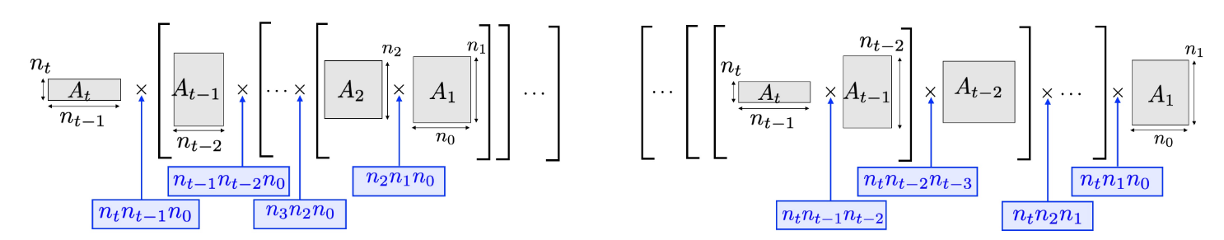

In [ ]:
class FeedForwardNN:
    def __init__(self, layer_sizes, seed=0):
        """
        layer_sizes: [input_dim, hidden1, ..., output_dim]
        """
        self.layer_sizes = layer_sizes
        self.num_layers = len(layer_sizes) - 1

        rng = np.random.default_rng(seed)

        self.W = []
        self.b = []

        for i in range(self.num_layers):
            in_dim = layer_sizes[i]
            out_dim = layer_sizes[i + 1]

            W = rng.standard_normal((out_dim, in_dim)) * np.sqrt(2.0 / in_dim)
            b = np.zeros(out_dim)

            self.W.append(W)
            self.b.append(b)

    @staticmethod
    def relu(z):
        "used for hidden layer activation"
        return np.maximum(0.0, z)

    @staticmethod
    def relu_grad(z):
        "used for hidden layer activation"
        return (z > 0).astype(float)

    def forward(self, x):
        """
        Returns output and cache needed for backprop
        """
        a = x
        cache = {
            "a": [x],  # activations
            "z": []    # pre-activations
        }

        for k in range(self.num_layers):
            z = self.W[k] @ a + self.b[k]
            cache["z"].append(z)

            if k < self.num_layers - 1:
                a = relu(z)
            else:
                a = z  # skip activation for output layer

            cache["a"].append(a)

        return a, cache

    def backward(self, cache, delta_L):
        """
        delta_L = dℓ/da^L (depends on the loss we choose)
        """
        grads_W = [None] * self.num_layers
        grads_b = [None] * self.num_layers
        delta = delta_L

        for k in reversed(range(self.num_layers)):
            a_prev = cache["a"][k]

            grads_W[k] = np.outer(delta, a_prev)
            grads_b[k] = delta

            if k > 0:
                delta = self.W[k].T @ delta
                delta *= relu_grad(cache["z"][k - 1])

        return grads_W, grads_b

    def predict(self, x):
        y_hat, _ = self.forward(x)
        return y_hat

    @staticmethod
    def squared_loss(y_hat, y):
        "used for regression"
        return 0.5 * np.sum((y_hat - y)**2)

    @staticmethod
    def squared_loss_grad(y_hat, y):
        "used for regression"
        return y_hat - y

    def train_step(self, x, y, lr=1e-2):
        "use for regression"
        y_hat, cache = self.forward(x)
        loss = self.squared_loss(y_hat, y) # for regression
        delta_L = self.squared_loss_grad(y_hat, y) # for regression

        grads_W, grads_b = self.backward(cache, delta_L)

        for k in range(self.num_layers):
            self.W[k] -= lr * grads_W[k]
            self.b[k] -= lr * grads_b[k]

        return loss

    def train(self, X, Y, lr=1e-2, epochs=10):
        "use for training"
        for epoch in range(epochs):
            total_loss = 0
            for x, y in zip(X, Y):
                total_loss += self.train_step(x, y, lr)
            print(f"Epoch {epoch}, avg loss: {total_loss/len(X):.4f}")


# example network: R^4 -> 5 -> 3 -> 1
nn = FeedForwardNN([4, 5, 3, 1])

rng = np.random.default_rng(1)
x = rng.standard_normal(4)
y = np.array([1.0])

print(nn.predict(x))
for step in range(20):
    loss = nn.train_step(x, y, lr=0.1)
    print(f"step {step}, loss {loss:.4f}")
print(nn.predict(x))


[-0.0002206]
step 0, loss 0.5002
step 1, loss 0.4050
step 2, loss 0.3280
step 3, loss 0.2657
step 4, loss 0.2152
step 5, loss 0.1743
step 6, loss 0.1412
step 7, loss 0.1144
step 8, loss 0.0926
step 9, loss 0.0750
step 10, loss 0.0608
step 11, loss 0.0492
step 12, loss 0.0399
step 13, loss 0.0323
step 14, loss 0.0262
step 15, loss 0.0212
step 16, loss 0.0172
step 17, loss 0.0139
step 18, loss 0.0113
step 19, loss 0.0091
[0.87842633]


## MNIST classification with Softmax + Cross-Entropy

MNIST is a **10-class classification problem**: each image is a $28 \times 28$ grayscale digit, and the label $y_i \in {0,1,\dots,9}$.

For multi-class problems, we want the network output to represent **class probabilities**. The **softmax** function achieves this:

$$
p_k = \frac{e^{z_k}}{\sum_{j=1}^{K} e^{z_j}}, \quad k=1,\dots,K
$$

and the **cross-entropy loss** measures the discrepancy between the predicted probabilities $p$ and the true class $y$:

$$
\ell(z, y) = -\log p_y
$$

A major advantage: the gradient of the softmax composed with cross-entropy is **simple**:

$$
\frac{\partial \ell}{\partial z_j} = p_j - \mathbf{1}_{j=y}
$$

so we **never have to compute the full Jacobian**, which is computationally efficient for large $K$ (like $K=10$ in MNIST).

### Changes to our `FeedForwardNN` class

To accommodate MNIST classification:

1. **Output layer activation**: keep logits linear (no activation) and apply softmax only inside the loss.
2. **Loss function**: replace squared loss with **cross-entropy**.
3. **Backward pass**: for the output layer, use the closed-form gradient $\delta^L = p - \mathbf{1}_y$.
4. Everything else (hidden layers, ReLU, weight updates) remains unchanged.

We will now slightly generalize the above class to handle both regression and classification problems.

In [ ]:
class FeedForwardNN:
    def __init__(self, layer_sizes, seed=0, classification=False):
        """
        layer_sizes: [input_dim, hidden1, ..., output_dim]
        classification: if True, use softmax + cross-entropy, else regression
        """
        self.layer_sizes = layer_sizes
        self.num_layers = len(layer_sizes) - 1
        self.classification = classification

        rng = np.random.default_rng(seed)

        self.W = []
        self.b = []

        for i in range(self.num_layers):
            in_dim = layer_sizes[i]
            out_dim = layer_sizes[i + 1]
            W = rng.standard_normal((out_dim, in_dim)) * np.sqrt(2.0 / in_dim)
            b = np.zeros(out_dim)
            self.W.append(W)
            self.b.append(b)

        self.W[-1] = rng.standard_normal((out_dim, in_dim)) * 0.01

    @staticmethod
    def relu(z):
        return np.maximum(0.0, z)

    @staticmethod
    def relu_grad(z):
        return (z > 0).astype(float)

    @staticmethod
    def softmax(z):
        z = z - np.max(z)         # numerical stability
        exp_z = np.exp(z)
        return exp_z / np.sum(exp_z)

    def forward(self, x):
        a = x
        cache = {"a": [x], "z": []}
        for k in range(self.num_layers):
            z = self.W[k] @ a + self.b[k]
            cache["z"].append(z)
            if k < self.num_layers - 1:
                a = self.relu(z)
            else:
                a = z  # output layer raw logits
            cache["a"].append(a)
        return a, cache

    def backward(self, cache, delta_L):
        grads_W = [None] * self.num_layers
        grads_b = [None] * self.num_layers
        delta = delta_L
        for k in reversed(range(self.num_layers)):
            a_prev = cache["a"][k]
            grads_W[k] = np.outer(delta, a_prev)
            grads_b[k] = delta
            if k > 0:
                delta = self.W[k].T @ delta
                delta *= self.relu_grad(cache["z"][k - 1])
        return grads_W, grads_b

    def predict(self, x):
        y_hat, _ = self.forward(x)
        if self.classification:
            return self.softmax(y_hat)
        return y_hat

    def predict_proba(self, x):
        logits, _ = self.forward(x)
        return self.softmax(logits)

    def predict_onehot(self, x):
        logits, _ = self.forward(x)
        return np.argmax(logits)

    @staticmethod
    def squared_loss(y_hat, y):
        return 0.5 * np.sum((y_hat - y)**2)

    @staticmethod
    def squared_loss_grad(y_hat, y):
        return y_hat - y

    @staticmethod
    def cross_entropy_loss(z, y):
        y = int(y)  # ensure integer label
        p = FeedForwardNN.softmax(z)
        return -np.log(p[y])

    @staticmethod
    def cross_entropy_grad(z, y):
        y = int(y)
        p = FeedForwardNN.softmax(z)
        p[y] -= 1.0
        return p

    def train_step(self, x, y, lr=1e-2):
        y_hat, cache = self.forward(x)
        if self.classification:
            loss = self.cross_entropy_loss(y_hat, y)
            delta_L = self.cross_entropy_grad(y_hat, y)
        else:
            loss = self.squared_loss(y_hat, y)
            delta_L = self.squared_loss_grad(y_hat, y)
        grads_W, grads_b = self.backward(cache, delta_L)
        for k in range(self.num_layers):
            self.W[k] -= lr * grads_W[k]
            self.b[k] -= lr * grads_b[k]
        return loss

    def train(self, X, Y, lr=1e-2, epochs=10):
        for epoch in range(epochs):
            total_loss = 0
            for x, y in zip(X, Y):
                total_loss += self.train_step(x, y, lr)
            print(f"Epoch {epoch}, avg loss: {total_loss/len(X):.4f}")


#### MNIST experiment

Now we are ready to use our new class on the MNIST problem. First, the setting and some definitions.

In [ ]:
# MNIST experiment with visualization
from sklearn.datasets import fetch_openml

# ------------------------------
# 1) Load small MNIST subset for speed
# ------------------------------
mnist = fetch_openml('mnist_784', version=1, as_frame=False)
X, y = mnist['data'].astype(np.float32)/255.0, mnist['target'].astype(int)

# small subset for demonstration
X_train, y_train = X[:2000], y[:2000]
X_test, y_test = X[2000:2100], y[2000:2100]

# define softmax
def softmax(z):
    z = z - np.max(z)
    exp_z = np.exp(z)
    return exp_z / np.sum(exp_z)

Define two different neural networks, and train them.

Training small NN...
Epoch 0, avg loss: 1.2102
Epoch 1, avg loss: 0.4583
Epoch 2, avg loss: 0.3417
Epoch 3, avg loss: 0.2748
Epoch 4, avg loss: 0.2219
Epoch 5, avg loss: 0.1789
Epoch 6, avg loss: 0.1423
Epoch 7, avg loss: 0.1136
Epoch 8, avg loss: 0.0904
Epoch 9, avg loss: 0.0723
Epoch 10, avg loss: 0.0574
Epoch 11, avg loss: 0.0454
Epoch 12, avg loss: 0.0366
Epoch 13, avg loss: 0.0293
Epoch 14, avg loss: 0.0243

Training big NN...
Epoch 0, avg loss: 1.2411
Epoch 1, avg loss: 0.4697
Epoch 2, avg loss: 0.3152
Epoch 3, avg loss: 0.2247
Epoch 4, avg loss: 0.1358
Epoch 5, avg loss: 0.0849
Epoch 6, avg loss: 0.0537
Epoch 7, avg loss: 0.0345
Epoch 8, avg loss: 0.0221
Epoch 9, avg loss: 0.0135
Epoch 10, avg loss: 0.0087
Epoch 11, avg loss: 0.0060
Epoch 12, avg loss: 0.0046
Epoch 13, avg loss: 0.0038
Epoch 14, avg loss: 0.0032


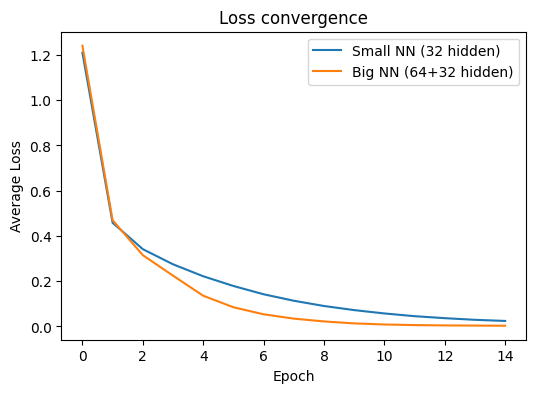

In [ ]:
# ------------------------------
# 2) Define two networks
# ------------------------------
# small network: 784 -> 32 -> 10
small_nn = FeedForwardNN([784, 32, 10], seed=0, classification=True)
# bigger network: 784 -> 64 -> 32 -> 10
big_nn = FeedForwardNN([784, 64, 32, 10], seed=1, classification=True)

# ------------------------------
# 3) Training loop with loss tracking
# ------------------------------
def train_with_loss_tracking(nn, X, Y, epochs=5, lr=0.01):
    losses = []
    for epoch in range(epochs):
        total_loss = 0
        for x, y in zip(X, Y):
            total_loss += nn.train_step(x, y, lr)
        avg_loss = total_loss / len(X)
        losses.append(avg_loss)
        print(f"Epoch {epoch}, avg loss: {avg_loss:.4f}")
    return losses

print("Training small NN...")
loss_small = train_with_loss_tracking(small_nn, X_train, y_train, epochs=15, lr=0.01)

print("\nTraining big NN...")
loss_big = train_with_loss_tracking(big_nn, X_train, y_train, epochs=15, lr=0.01)

# ------------------------------
# 4) Plot loss curves
# ------------------------------
plt.figure(figsize=(6,4))
plt.plot(loss_small, label='Small NN (32 hidden)')
plt.plot(loss_big, label='Big NN (64+32 hidden)')
plt.xlabel("Epoch")
plt.ylabel("Average Loss")
plt.title("Loss convergence")
plt.legend()
plt.show()

Test accuracy

In [ ]:
# ------------------------------
# 5) Test accuracy
# ------------------------------
def evaluate_accuracy(nn, X_test, y_test):
    correct = 0
    for x, y in zip(X_test, y_test):
        logits = nn.predict(x)            # shape (K,)
        pred_class = np.argmax(logits)    # take class with highest logit
        if pred_class == y:
            correct += 1
    acc = correct / len(y_test)
    print(f"Accuracy: {acc:.3f}")
    return acc

print("Small NN Test Accuracy:")
acc_small = evaluate_accuracy(small_nn, X_test, y_test)

print("Big NN Test Accuracy:")
acc_big = evaluate_accuracy(big_nn, X_test, y_test)

Small NN Test Accuracy:
Accuracy: 0.890
Big NN Test Accuracy:
Accuracy: 0.920


Use the trained networks for a random test.

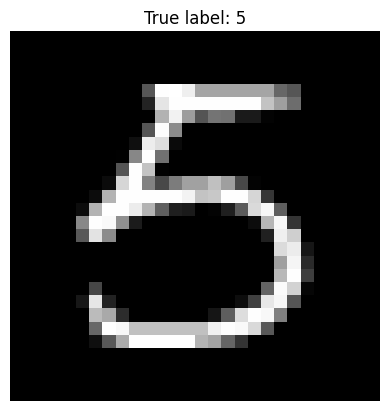

Predicted by small NN: 5
Predicted by big NN  : 5


In [ ]:
# ------------------------------
# 6) Visual test: pick a random digit
# ------------------------------
idx = np.random.randint(len(X_test))
x_digit = X_test[idx]
y_true = y_test[idx]

# reshape to 28x28 for display
plt.imshow(x_digit.reshape(28,28), cmap='gray')
plt.title(f"True label: {y_true}")
plt.axis('off')
plt.show()

# predict with both networks
pred_small = small_nn.predict_onehot(x_digit)
pred_big = big_nn.predict_onehot(x_digit)

print(f"Predicted by small NN: {pred_small}")
print(f"Predicted by big NN  : {pred_big}")

## Accelerating Gradient Descent with Momentum

So far, we have updated our network parameters using **vanilla stochastic gradient descent (SGD)**:

$$
\theta^{(t+1)} = \theta^{(t)} - \eta , \nabla_\theta \ell(\theta^{(t)}),
$$

where $\theta$ represents the weights and biases, $\eta$ is the learning rate, and $\nabla_\theta \ell(\theta)$ is the gradient of the loss with respect to $\theta$.

While this method is simple, it can be slow to converge, especially in regions where the loss surface has **steep and shallow directions** (ill-conditioned valleys). The updates may oscillate along the steep directions and progress slowly along shallow directions.

To accelerate convergence, we introduce **momentum**, which accumulates a running velocity vector for each parameter:

$$
v^{(t+1)} = \mu , v^{(t)} - \eta , \nabla_\theta \ell(\theta^{(t)}),
$$

$$
\theta^{(t+1)} = \theta^{(t)} + v^{(t+1)}.
$$

Here:

* $v^{(t)}$ is the velocity at step $t$,
* $\mu \in [0,1)$ is the **momentum coefficient** controlling how much of the previous velocity is retained,
* $\eta$ is the learning rate,
* $\nabla_\theta \ell(\theta^{(t)})$ is the current gradient.

Intuitively, momentum acts like a **ball rolling down a slope**: it accumulates speed along directions with consistent gradients, smoothing out oscillations, and allowing faster convergence along shallow directions.

In our `FeedForwardNN` class, we implement momentum for all weights and biases by keeping separate velocity arrays (`vW` and `vb`) and updating them at each training step:

```python
self.vW[k] = momentum * self.vW[k] - lr * grads_W[k]
self.vb[k] = momentum * self.vb[k] - lr * grads_b[k]
self.W[k] += self.vW[k]
self.b[k] += self.vb[k]
```

This allows the network to **accelerate learning** compared to standard SGD, particularly for deeper networks or when the optimization landscape is highly anisotropic.

---

If you want, I can also draft a **small figure** showing the difference between **SGD vs SGD with momentum** along a valley, which looks really nice for students.

Do you want me to add that figure?


Training NN with SGD...
Epoch 0, avg loss: 1.8640
Epoch 1, avg loss: 1.1071
Epoch 2, avg loss: 0.7270
Epoch 3, avg loss: 0.5569
Epoch 4, avg loss: 0.4619
Training NN with SGD + momentum...
Epoch 0, avg loss: 0.9142
Epoch 1, avg loss: 0.3905
Epoch 2, avg loss: 0.2626
Epoch 3, avg loss: 0.1812
Epoch 4, avg loss: 0.1069


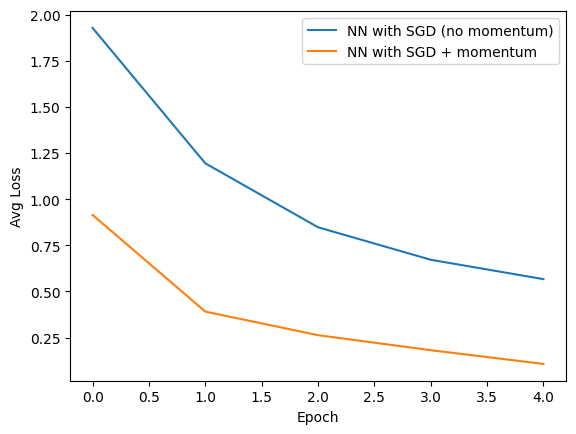

NN without momentum Test Accuracy: 0.868
NN with    momentum Test Accuracy: 0.902


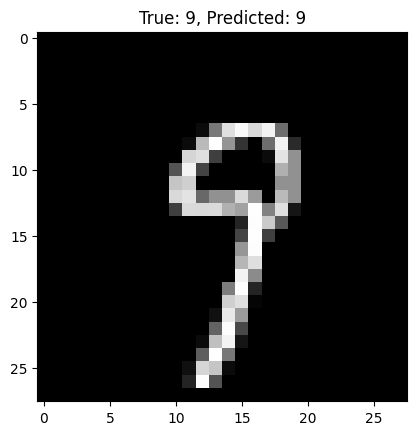

In [ ]:
import numpy as np
import matplotlib.pyplot as plt

class FeedForwardNN:
    def __init__(self, layer_sizes, seed=0):
        self.layer_sizes = layer_sizes
        self.num_layers = len(layer_sizes) - 1

        rng = np.random.default_rng(seed)
        self.W = []
        self.b = []

        for i in range(self.num_layers):
            in_dim = layer_sizes[i]
            out_dim = layer_sizes[i+1]
            W = rng.standard_normal((out_dim, in_dim)) * np.sqrt(2.0 / in_dim)
            b = np.zeros(out_dim)
            self.W.append(W)
            self.b.append(b)

        # Initialize momentum terms
        self.vW = [np.zeros_like(W) for W in self.W]
        self.vb = [np.zeros_like(b) for b in self.b]

    @staticmethod
    def relu(z):
        return np.maximum(0.0, z)

    @staticmethod
    def relu_grad(z):
        return (z > 0).astype(float)

    @staticmethod
    def softmax(z):
        z = z - np.max(z)  # numerical stability
        exp_z = np.exp(z)
        return exp_z / np.sum(exp_z)

    def forward(self, x):
        a = x
        cache = {"a":[x], "z":[]}
        for k in range(self.num_layers):
            z = self.W[k] @ a + self.b[k]
            cache["z"].append(z)
            if k < self.num_layers - 1:
                a = self.relu(z)
            else:
                a = z
            cache["a"].append(a)
        return a, cache

    def backward(self, cache, delta_L):
        grads_W = [None]*self.num_layers
        grads_b = [None]*self.num_layers
        delta = delta_L
        for k in reversed(range(self.num_layers)):
            a_prev = cache["a"][k]
            grads_W[k] = np.outer(delta, a_prev)
            grads_b[k] = delta
            if k > 0:
                delta = self.W[k].T @ delta
                delta *= self.relu_grad(cache["z"][k-1])
        return grads_W, grads_b

    @staticmethod
    def cross_entropy_loss(z, y):
        p = FeedForwardNN.softmax(z)
        return -np.log(p[y])

    @staticmethod
    def cross_entropy_grad(z, y):
        p = FeedForwardNN.softmax(z)
        p[y] -= 1.0
        return p

    def train_step(self, x, y, lr=1e-2, momentum=0.0):
        y_hat, cache = self.forward(x)
        delta_L = self.cross_entropy_grad(y_hat, y)
        grads_W, grads_b = self.backward(cache, delta_L)

        # SGD update with momentum
        for k in range(self.num_layers):
            self.vW[k] = momentum * self.vW[k] - lr * grads_W[k]
            self.vb[k] = momentum * self.vb[k] - lr * grads_b[k]
            self.W[k] += self.vW[k]
            self.b[k] += self.vb[k]

        loss = self.cross_entropy_loss(y_hat, y)
        return loss

    def predict(self, x):
        logits, _ = self.forward(x)
        return np.argmax(logits)

    def train(self, X, Y, lr=1e-2, epochs=5, momentum=0.0):
        loss_history = []
        for epoch in range(epochs):
            total_loss = 0
            for x, y in zip(X, Y):
                loss = self.train_step(x, y, lr=lr, momentum=momentum)
                total_loss += loss
            avg_loss = total_loss / len(X)
            loss_history.append(avg_loss)
            print(f"Epoch {epoch}, avg loss: {avg_loss:.4f}")
        return loss_history

# --- MNIST setup ---
from sklearn.datasets import fetch_openml

mnist = fetch_openml('mnist_784', version=1, as_frame=False)
X, y = mnist['data'].astype(np.float32)[:2000]/255.0, mnist['target'][:2000].astype(int)  # subset for speed
X_train, y_train = X[:1500], y[:1500]
X_test, y_test = X[1500:], y[1500:]

# --- Two networks ---
nn_wo_mom = FeedForwardNN([784, 64, 32, 10])
nn_wi_mom = FeedForwardNN([784, 64, 32, 10])

print("Training NN with SGD...")
loss_wo_mom = nn_wo_mom.train(X_train, y_train, lr=0.001, epochs=5, momentum=0.0)

print("Training NN with SGD + momentum...")
loss_wi_mom = nn_wi_mom.train(X_train, y_train, lr=0.001, epochs=5, momentum=0.9)

# --- Plot loss ---
plt.plot(loss_small, label="NN with SGD (no momentum)")
plt.plot(loss_big, label="NN with SGD + momentum")
plt.xlabel("Epoch")
plt.ylabel("Avg Loss")
plt.legend()
plt.show()

# --- Test accuracy ---
def evaluate_accuracy(nn, X_test, y_test):
    correct = 0
    for x, y in zip(X_test, y_test):
        pred = nn.predict(x)
        if pred == y:
            correct += 1
    return correct / len(y_test)

acc_wo = evaluate_accuracy(nn_wo_mom, X_test, y_test)
acc_wi   = evaluate_accuracy(nn_wi_mom, X_test, y_test)

print(f"NN without momentum Test Accuracy: {acc_wo:.3f}")
print(f"NN with    momentum Test Accuracy: {acc_wi:.3f}")
